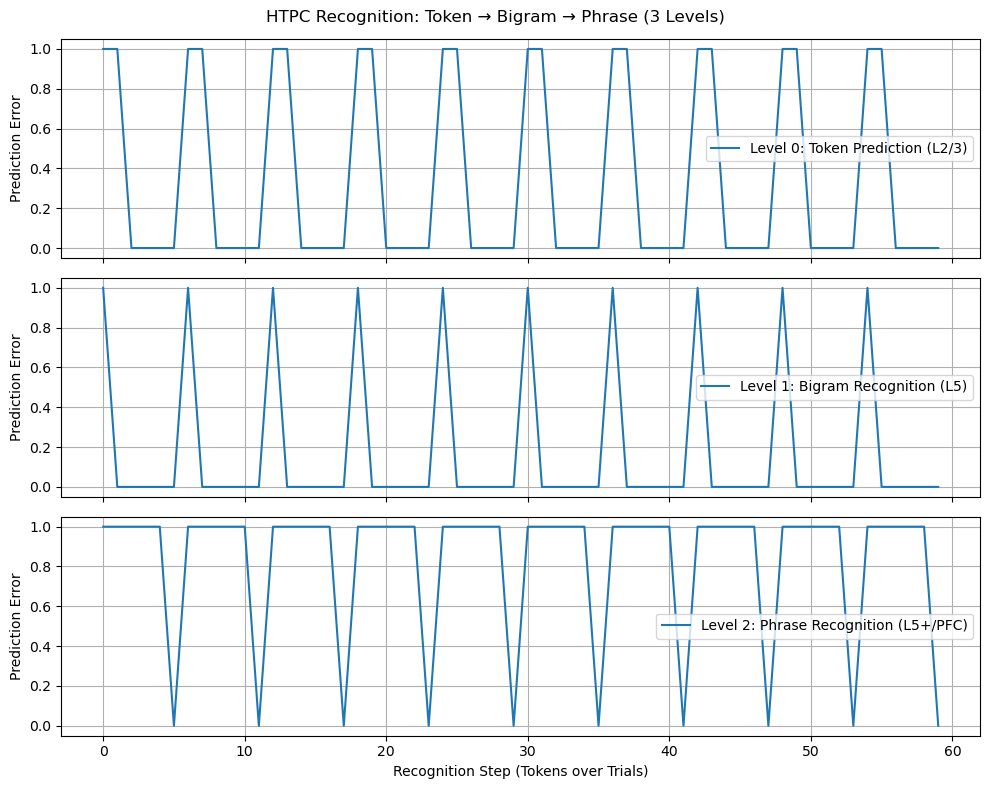

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === Define the input sentence ===
token_sequence = ['the', 'dog', 'ran', 'in', 'the', 'park']
n_tokens = len(token_sequence)
n_levels = 3  # Level 0 = token-level, 1 = bigram, 2 = full phrase
n_trials = 10

# === Bigram memory (Level 1): stores 2-token patterns ===
bigram_memory = {
    ('the', 'dog'): np.array([1, 1, 0, 0, 0, 0]),
    ('dog', 'ran'): np.array([0, 1, 1, 0, 0, 0]),
    ('ran', 'in'):  np.array([0, 0, 1, 1, 0, 0]),
    ('in', 'the'):  np.array([0, 0, 0, 1, 1, 0]),
    ('the', 'park'): np.array([0, 0, 0, 0, 1, 1]),
}

# === Phrase memory (Level 2): full 6-token phrase as a chain of bigrams ===
phrase_memory = {
    (('the', 'dog'), ('dog', 'ran'), ('ran', 'in'),
     ('in', 'the'), ('the', 'park')): np.ones(n_tokens)
}

# === Token-level transition memory (Level 0) ===
token_prediction_matrix = {
    'the': 'dog',
    'dog': 'ran',
    'ran': 'in',
    'in': 'the',
    'the': 'park',
    'park': None
}

# === Data containers ===
level_predictions = [np.zeros(n_tokens) for _ in range(n_levels)]
prediction_errors = [[] for _ in range(n_levels)]

# === Simulate multiple recognition trials ===
for trial in range(n_trials):
    for i, token in enumerate(token_sequence):
        actual = 1.0  # L4 receives input

        # === Level 0: token-to-token prediction (temporal) ===
        predicted_token = None
        if i > 0:
            predicted_token = token_prediction_matrix.get(token_sequence[i - 1], None)
        low_pred = 1.0 if predicted_token == token else 0.0
        level_predictions[0][i] = low_pred
        prediction_errors[0].append(abs(actual - low_pred))

        # === Level 1: bigram prediction from 2-token memory ===
        bigram_pred_vector = np.zeros(n_tokens)
        if i > 0:
            bigram = (token_sequence[i - 1], token)
            if bigram in bigram_memory:
                bigram_pred_vector = bigram_memory[bigram]
        bigram_pred = bigram_pred_vector[i]
        level_predictions[1][i] = bigram_pred
        prediction_errors[1].append(abs(actual - bigram_pred))

        # === Level 2: phrase recognition from bigram sequence ===
        phrase_pred_vector = np.zeros(n_tokens)
        if i >= 5:  # only valid once all bigrams are present
            phrase = tuple((token_sequence[j], token_sequence[j + 1]) for j in range(i - 5, i))
            if phrase in phrase_memory:
                phrase_pred_vector = phrase_memory[phrase]
        phrase_pred = phrase_pred_vector[i]
        level_predictions[2][i] = phrase_pred
        prediction_errors[2].append(abs(actual - phrase_pred))

# === Plot prediction error per level ===
fig, ax = plt.subplots(n_levels, 1, figsize=(10, 8), sharex=True)
labels = ['Level 0: Token Prediction (L2/3)',
          'Level 1: Bigram Recognition (L5)',
          'Level 2: Phrase Recognition (L5+/PFC)']

for lvl in range(n_levels):
    ax[lvl].plot(prediction_errors[lvl], label=labels[lvl])
    ax[lvl].set_ylabel("Prediction Error")
    ax[lvl].legend()
    ax[lvl].grid(True)

ax[-1].set_xlabel("Recognition Step (Tokens over Trials)")
plt.suptitle("HTPC Recognition: Token → Bigram → Phrase (3 Levels)")
plt.tight_layout()
plt.show()
